# Tool Loadout

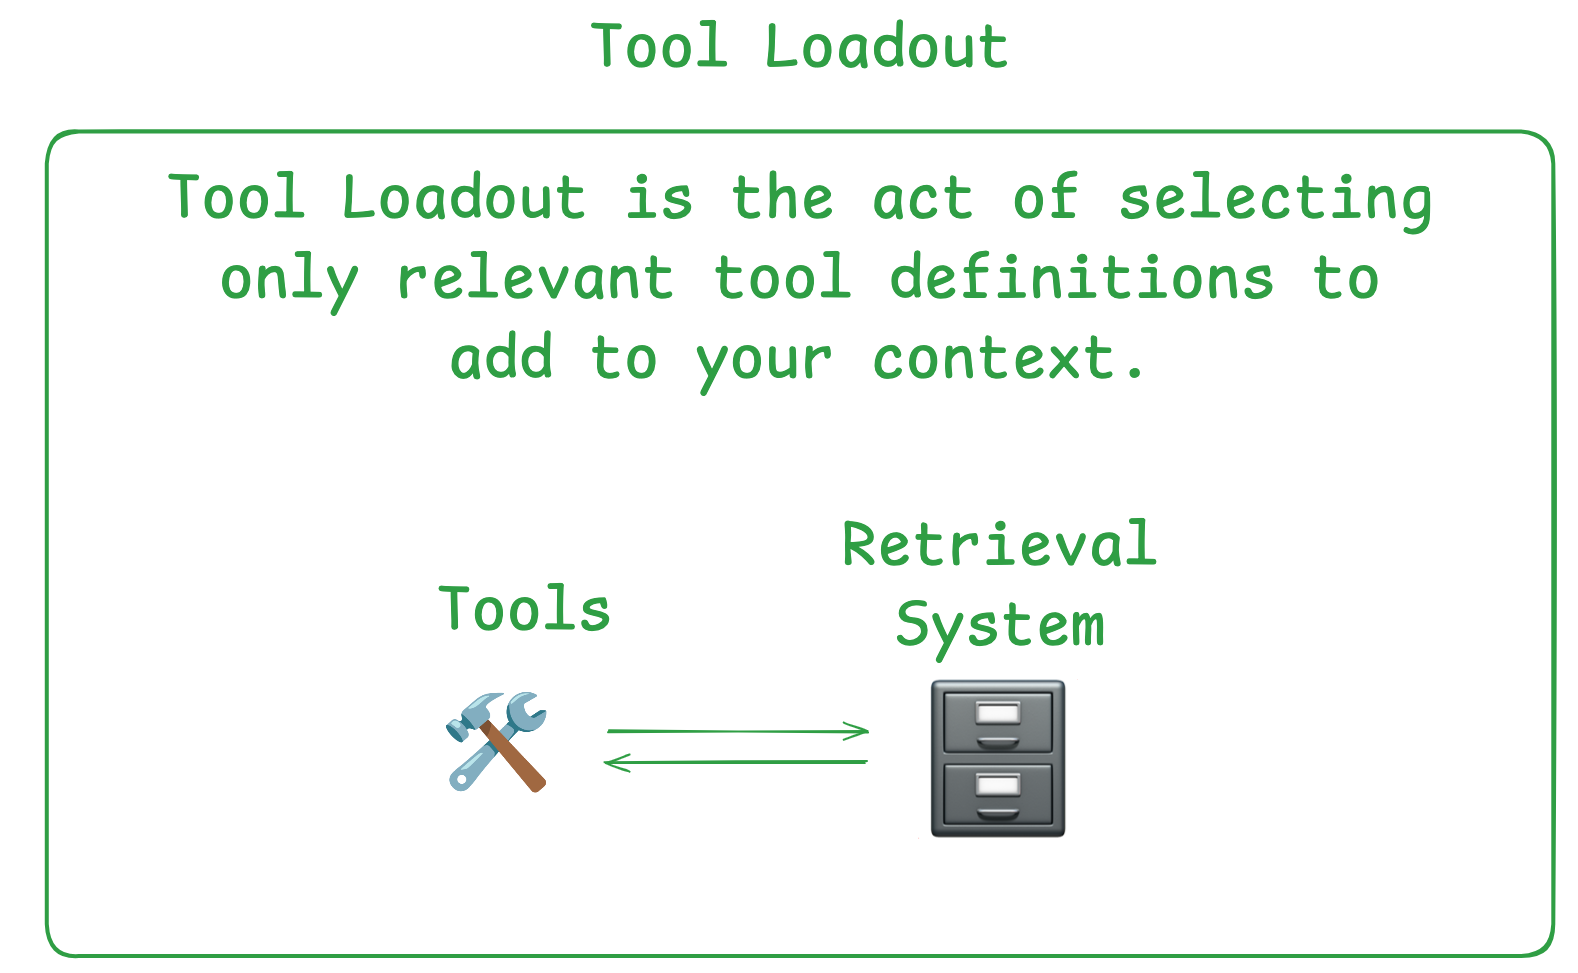

## What it is

*Tool Loadout is the act of selecting only relevant tool definitions to add to your context.*

## Why it helps

* Avoids [Context Confusion](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html): Context Confusion happens when superfluous information in the context is used by the model to generate a low-quality response. This is common when working with large tool collections; tool descriptions can begin to overlap, creating confusion about which one to use.

* Can improve tool selection: Walden Yan mentioned that *[“universal tools often beat specialized ones”](https://x.com/jxnlco/status/1945490018127987092)*. As an example, general‑purpose tools (e.g., shell access) can outperform more narrow ones. Bloating the model context with a large number of narrow and potentially overlapping tool descriptions can degrade performance. 

## Tool Loadout in Practice

Drew summarizes some [recent papers](https://arxiv.org/abs/2505.03275) that show the practical benefits of tool loadout. As an example:

- Llama 3.1 8b fails with 46 tools** but performs better with 19 tools
- Dynamic tool selection improved Llama 3.1 8b performance by 44%

## Tool selecting in LangGraph

The [LangGraph Bigtool](https://github.com/langchain-ai/langgraph-bigtool) library is a great way to apply semantic similarity search over tool descriptions for selection of the most relevant tools for a task. It leverages LangGraph's long-term memory store to allow an agent to search for and retrieve relevant tools for a given problem. 

Lets implement what happens under the hood of `langgraph-bigtool` from scratch. We'll equip an agent with all functions from Python's built-in math library!

In [1]:
import getpass
import math  
import os
import types
import uuid

from langchain.chat_models import init_chat_model
from langchain.embeddings import init_embeddings

from langgraph.store.memory import InMemoryStore

from langgraph_bigtool.utils import convert_positional_only_function_to_tool

def _set_env(var: str) -> None:
    """Set environment variable if not already set.
    
    Args:
        var: Environment variable name to set
    """
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Configure API keys for OpenAI and Anthropic services
_set_env("OPENAI_API_KEY")
_set_env("ANTHROPIC_API_KEY")

# Initialize the primary language model for the agent
llm = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0)

# Extract and convert all mathematical functions from Python's math module
all_tools = []
for function_name in dir(math):
    function = getattr(math, function_name)
    
    # Only process built-in mathematical functions
    if not isinstance(function, types.BuiltinFunctionType):
        continue
        
    # Convert math functions to LangChain tools (handles positional-only parameters)
    if tool := convert_positional_only_function_to_tool(function):
        all_tools.append(tool)

# Create a tool registry mapping unique IDs to tool instances
# This allows for efficient tool lookup and management
tool_registry = {
    str(uuid.uuid4()): tool
    for tool in all_tools
}

# Set up vector store for semantic tool search
# Uses embeddings to enable similarity-based tool selection
embeddings = init_embeddings("openai:text-embedding-3-small")

store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,  # OpenAI embedding dimensions
        "fields": ["description"],  # Index tool descriptions for search
    }
)

# Index all tools in the store for semantic similarity search
for tool_id, tool in tool_registry.items():
    store.put(
        ("tools",),  # Namespace for tool storage
        tool_id,
        {
            "description": f"{tool.name}: {tool.description}",
        },
    )

/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_23522/760372056.py:40: LangChainBetaWarning: The function `convert_positional_only_function_to_tool` is in beta. It is actively being worked on, so the API may change.
  if tool := convert_positional_only_function_to_tool(function):


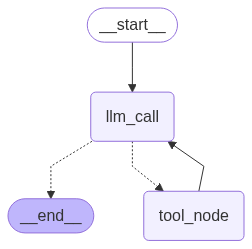

In [3]:
# Import organization: Type hints and third-party packages
from typing import Dict, Any
from typing_extensions import Literal

# LangChain core components
from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage

# LangGraph components for workflow and state management
from langgraph.store.base import BaseStore
from langgraph.graph import END, START, StateGraph, MessagesState

# Jupyter display utilities
from IPython.display import Image, display

# Extended state class to store dynamically selected tools
class ToolLoadoutState(MessagesState):
    """State that extends MessagesState to include dynamically selected tools.
    
    This allows the agent to maintain context about which tools are currently
    available and bound to the conversation.
    """
    tools_by_name: Dict[str, Any] = {}

# System prompt defining the agent's role and capabilities
system_prompt = """You are a helpful assistant with access to mathematical functions from Python's math library. 
You can search for and use relevant mathematical tools to solve problems. 
When you need to perform mathematical calculations, first determine what type of mathematical operation you need, 
then use the appropriate tools from the math library."""

def llm_call(state: ToolLoadoutState, store: BaseStore) -> dict:
    """Main LLM call that dynamically selects and binds relevant tools.
    
    This function implements the core tool loadout pattern:
    1. Extract query context from user message
    2. Search for semantically relevant tools  
    3. Bind only relevant tools to the LLM
    4. Generate response with focused tool set
    
    Args:
        state: Current conversation state containing messages and tools
        store: Vector store containing indexed tool descriptions
        
    Returns:
        Dictionary with new messages and updated tool registry
    """
    # Extract user query for semantic tool search
    messages = state["messages"]
    if messages and isinstance(messages[-1], HumanMessage):
        query = messages[-1].content
    else:
        query = "mathematical calculation"  # Default fallback
    
    # Perform semantic similarity search to find relevant tools
    search_results = store.search(("tools",), query=query, limit=5)
    
    # Build focused tool set from search results
    relevant_tools = []
    tools_by_name = {}
    
    for result in search_results:
        tool_id = result.key
        if tool_id in tool_registry:
            tool = tool_registry[tool_id]
            relevant_tools.append(tool)
            tools_by_name[tool.name] = tool
    
    # Bind only relevant tools to avoid context overload
    llm_with_tools = llm.bind_tools(relevant_tools) if relevant_tools else llm
    
    # Generate response with focused context
    response = llm_with_tools.invoke(
        [SystemMessage(content=system_prompt)] + state["messages"]
    )
    
    return {
        "messages": [response],
        "tools_by_name": tools_by_name
    }

def tool_node(state: ToolLoadoutState) -> dict:
    """Execute tool calls using the dynamically selected tool set.
    
    Args:
        state: Current conversation state with tool calls
        
    Returns:
        Dictionary with tool execution results
    """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        # Retrieve tool from the focused set stored in state
        tool = state["tools_by_name"][tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=str(observation), tool_call_id=tool_call["id"]))
    return {"messages": result}

def should_continue(state: ToolLoadoutState) -> Literal["tool_node", "__end__"]:
    """Determine workflow continuation based on tool calls.
    
    Args:
        state: Current conversation state
        
    Returns:
        Next node name or END
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    # Continue to tool execution if LLM made tool calls
    if last_message.tool_calls:
        return "tool_node"
    
    # Otherwise end the conversation
    return END

# Build the tool loadout workflow
agent_builder = StateGraph(ToolLoadoutState)

# Add workflow nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Define workflow edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node",
        END: END,
    },
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent with tool store for semantic search
agent = agent_builder.compile(store=store)

# Display the workflow graph
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [9]:
from utils import format_messages
from langchain_core.messages import HumanMessage

query = "Use available tools to calculate arc cosine of 0.5."
result = agent.invoke({"messages": [HumanMessage(content=query)]})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Use available tools to calculate arc cosine of 0.5.                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll calculate the arc cosine of 0.5 using the available acos function.                                         │
│                                                                                                                 │
│ 🔧 Tool Call: acos                                                                                              │
│    Args: {                                                                                                      │
│   "x": 0.5                                                                                                      │
│ }                                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 1.0471975511965976                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The arc cosine of 0.5 is approximately 1.047 radians, which equals π/3 radians or 60 degrees.                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Looking at the [trace](https://smith.langchain.com/public/ee81c189-3b60-45fc-a6f0-83d6de190a5d/r), we can see:

* We only pull in a 5 tools based upon the query. 
* The model correctly selects the `acos` tool to use. 